# Creep Protocol Validation

**Validates creep data: J(t) = γ(t)/σ₀ (creep compliance vs time)**

## Protocol Description

Creep experiments apply a constant stress (σ₀) and measure the resulting strain γ(t) over time.
The creep compliance J(t) = γ(t)/σ₀ characterizes the material's time-dependent deformation.

## Validation Checks

1. **Schema validation**: Required columns present (time, compliance or strain)
2. **Finite values**: No NaN or Inf in data arrays
3. **Positive time**: t > 0 (strictly positive)
4. **Monotonic time**: Time strictly increasing
5. **Positive compliance**: J(t) > 0
6. **Monotonic compliance**: J(t) monotonically increasing (for viscoelastic materials)

## Standard Plots

- J(t) vs t (log-log)
- J(t) vs t (linear)

In [1]:
# Configuration
MODE = "FAST"  # "FAST" or "FULL"

if MODE == "FAST":
    MAX_FILES = 2
    SKIP_HEAVY_PLOTS = True
    SAVE_ARTIFACTS = False
else:
    MAX_FILES = None
    SKIP_HEAVY_PLOTS = False
    SAVE_ARTIFACTS = True

print(f"Running in {MODE} mode")

Running in FAST mode


In [2]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add project root to path
project_root = Path.cwd()
while not (project_root / "pyproject.toml").exists() and project_root != project_root.parent:
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from examples.verification.utils.validation_utils import (
    DatasetValidation,
    ValidationResult,
    check_finite,
    check_monotonic,
    check_positive,
    create_output_directories,
    discover_files_by_protocol,
    get_data_dir,
    plot_creep,
    print_validation_summary,
    write_validation_report,
)

print(f"Project root: {project_root}")

Project root: /Users/b80985/Projects/rheojax


## A) Dataset Inventory

In [3]:
data_dir = get_data_dir()
files = discover_files_by_protocol(data_dir, "creep")

# Filter to main creep files (not export fragments)
files = [f for f in files if "creep_" in f.name and "export_" not in f.name]

print(f"Found {len(files)} creep data files:")
for i, f in enumerate(files):
    print(f"  {i+1}. {f.relative_to(data_dir)}")

if MAX_FILES is not None:
    files = files[:MAX_FILES]
    print(f"\nProcessing {len(files)} files (FAST mode)")

Found 9 creep data files:
  1. creep/creep_experiment.txt
  2. creep/biological/creep_mucus_data.csv
  3. creep/biological/creep_mucus_data_julia.csv
  4. creep/biological/creep_perihepatic_data.csv
  5. creep/polymers/creep_ps130_data.csv
  6. creep/polymers/creep_ps145_data.csv
  7. creep/polymers/creep_ps160_data.csv
  8. creep/polymers/creep_ps175_data.csv
  9. creep/polymers/creep_ps190_data.csv

Processing 2 files (FAST mode)


## B) Data Loading

In [4]:
def load_creep_data(file_path: Path) -> tuple[np.ndarray, np.ndarray, str]:
    """Load creep data with format auto-detection.
    
    Returns:
        Tuple of (time, J, status_message)
    """
    # Try different separators
    for sep in ["\t", ",", ";"]:
        try:
            df = pd.read_csv(file_path, sep=sep)
            if len(df.columns) >= 2:
                break
        except Exception:
            continue
    else:
        return None, None, "Could not parse file"
    
    # Find time column
    time_cols = [c for c in df.columns if "time" in c.lower() or c.lower() == "t"]
    if not time_cols:
        time_col = df.columns[0]
    else:
        time_col = time_cols[0]
    
    # Find compliance or strain column
    j_cols = [c for c in df.columns if "compliance" in c.lower() or "j" in c.lower()]
    strain_cols = [c for c in df.columns if "strain" in c.lower() or "gamma" in c.lower()]
    
    if j_cols:
        j_col = j_cols[0]
        is_compliance = True
    elif strain_cols:
        j_col = strain_cols[0]
        is_compliance = False
    else:
        j_col = df.columns[1] if len(df.columns) > 1 else None
        is_compliance = True
    
    if j_col is None:
        return None, None, "No compliance/strain column found"
    
    try:
        time = pd.to_numeric(df[time_col], errors="coerce").values
        J = pd.to_numeric(df[j_col], errors="coerce").values
    except Exception as e:
        return None, None, f"Numeric conversion failed: {e}"
    
    # Remove NaN values
    mask = np.isfinite(time) & np.isfinite(J)
    time = time[mask]
    J = J[mask]
    
    data_type = "compliance" if is_compliance else "strain"
    return time, J, f"Loaded {len(time)} points ({data_type}) from {time_col}, {j_col}"

# Test loading
if files:
    test_file = files[0]
    time, J, msg = load_creep_data(test_file)
    print(f"Test load: {test_file.name}")
    print(f"  {msg}")
    if time is not None:
        print(f"  t range: [{time.min():.2e}, {time.max():.2e}] s")
        print(f"  J range: [{J.min():.2e}, {J.max():.2e}] 1/Pa")

Test load: creep_experiment.txt
  Could not parse file


## C) Validation Pipeline

In [5]:
def validate_creep(file_path: Path) -> DatasetValidation:
    """Run all validation checks on a creep file."""
    validation = DatasetValidation(
        file_path=str(file_path),
        protocol="creep",
    )
    
    time, J, load_msg = load_creep_data(file_path)
    
    if time is None:
        validation.results.append(ValidationResult(
            check_name="data_loading",
            passed=False,
            message=load_msg,
        ))
        return validation
    
    validation.results.append(ValidationResult(
        check_name="data_loading",
        passed=True,
        message=load_msg,
        details={"n_points": len(time)},
    ))
    
    # Check 1: Finite values
    validation.results.append(check_finite(time, "time"))
    validation.results.append(check_finite(J, "compliance"))
    
    # Check 2: Positive time
    validation.results.append(check_positive(time, "time", strict=True))
    
    # Check 3: Monotonic time
    validation.results.append(check_monotonic(time, "time", increasing=True, strict=True))
    
    # Check 4: Positive compliance
    validation.results.append(check_positive(J, "compliance", strict=True))
    
    # Check 5: Monotonic compliance (informational - can fail for recovery)
    mono_result = check_monotonic(J, "compliance", increasing=True, strict=False)
    # Make it informational (always pass, just report)
    validation.results.append(ValidationResult(
        check_name="compliance_trend",
        passed=True,
        message=mono_result.message + (" (expected for creep)" if mono_result.passed else " (recovery phase detected)"),
        details=mono_result.details,
    ))
    
    validation.derived_quantities = {
        "time": time,
        "J": J,
    }
    
    return validation

In [6]:
# Run validation on all files
validations = []

for file_path in files:
    print(f"\nValidating: {file_path.name}")
    v = validate_creep(file_path)
    validations.append(v)
    
    for r in v.results:
        status = "PASS" if r.passed else "FAIL"
        print(f"  [{status}] {r.check_name}: {r.message}")


Validating: creep_experiment.txt
  [FAIL] data_loading: Could not parse file

Validating: creep_mucus_data.csv
  [PASS] data_loading: Loaded 20 points (compliance) from Time, Creep Compliance
  [PASS] finite_values_time: time: all 20 values finite
  [PASS] finite_values_compliance: compliance: all 20 values finite
  [PASS] positive_time: time: all 20 values positive (> 0)
  [PASS] monotonic_time: time: all 19 intervals strictly increasing
  [PASS] positive_compliance: compliance: all 20 values positive (> 0)
  [PASS] compliance_trend: compliance: all 19 intervals non-decreasing (expected for creep)


## D) Standard Plots

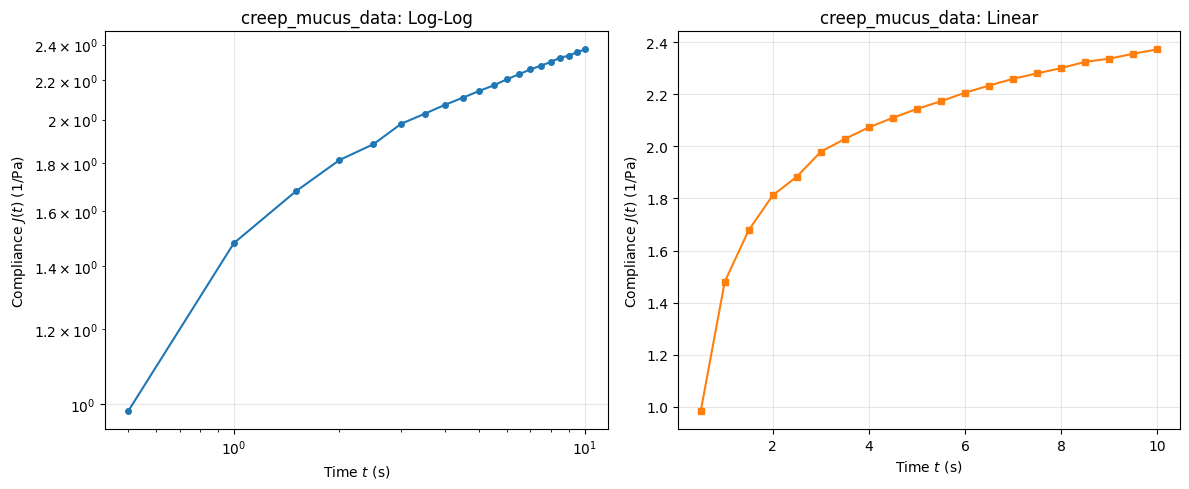

In [7]:
if not SKIP_HEAVY_PLOTS:
    output_paths = create_output_directories("creep")
    
    for v in validations:
        if v.passed and "time" in v.derived_quantities:
            file_name = Path(v.file_path).stem
            save_path = output_paths["plots"] / f"{file_name}_creep.png" if SAVE_ARTIFACTS else None
            
            fig = plot_creep(
                v.derived_quantities["time"],
                v.derived_quantities["J"],
                save_path=save_path,
                title=file_name,
            )
            plt.show()
else:
    for v in validations:
        if v.passed and "time" in v.derived_quantities:
            fig = plot_creep(
                v.derived_quantities["time"],
                v.derived_quantities["J"],
                title=Path(v.file_path).stem,
            )
            plt.show()
            break

## E) Validation Summary

In [8]:
print_validation_summary(validations)


Validation Summary
File                                     Status     Passed   Failed  
--------------------------------------------------------------------------------
creep_experiment.txt                     FAIL       0        1       
creep_mucus_data.csv                     PASS       7        0       
--------------------------------------------------------------------------------
TOTAL                                    SOME FAIL  7        1       


## F) Export Artifacts

In [9]:
if SAVE_ARTIFACTS:
    output_paths = create_output_directories("creep")
    
    report = {
        "protocol": "creep",
        "mode": MODE,
        "n_files_validated": len(validations),
        "all_passed": all(v.passed for v in validations),
        "validations": validations,
    }
    
    report_path = output_paths["plots"].parent / "validation_report.json"
    write_validation_report(report, report_path)
    print(f"Validation report saved to: {report_path}")
    
    for v in validations:
        if v.passed and "time" in v.derived_quantities:
            file_name = Path(v.file_path).stem
            df = pd.DataFrame({
                "time": v.derived_quantities["time"],
                "J": v.derived_quantities["J"],
            })
            df.to_csv(output_paths["derived_quantities"] / f"{file_name}_derived.csv", index=False)
    
    print(f"Derived quantities saved to: {output_paths['derived_quantities']}")
else:
    print("Artifacts not saved (FAST mode). Set MODE='FULL' to save.")

Artifacts not saved (FAST mode). Set MODE='FULL' to save.
